# <a id='toc1_'></a>[TP1 - Clasificación de Textos en 20 Newsgroups](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [TP1 - Clasificación de Textos en 20 Newsgroups](#toc1_)    
  - [Introducción](#toc1_1_)    
    - [Consigna](#toc1_1_1_)    
    - [Integrantes del grupo](#toc1_1_2_)    
  - [Resolución](#toc1_2_)    
    - [EDA](#toc1_2_1_)    
      - [Balance de clases](#toc1_2_1_1_)    
      - [Frecuencias de palabras (raw)](#toc1_2_1_2_)    
      - [Longitudes (raw)](#toc1_2_1_3_)    
    - [Métrica](#toc1_2_2_)    
    - [Preprocessing de la data](#toc1_2_3_)    
      - [Archivos](#toc1_2_3_1_)    
    - [EDA_v2](#toc1_2_4_)    
      - [Vocabulario vs mindf vs maxdf](#toc1_2_4_1_)    
    - [Train](#toc1_2_5_)    
      - [Pipeline & Hyperparameters & GridSearch](#toc1_2_5_1_)    
    - [Resultados: validación en train y test](#toc1_2_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introducción](#toc0_)

### <a id='toc1_1_1_'></a>[Consigna](#toc0_)

Se trabajará con los datos de 20 Newsgroups.

Se pide:

* Realizar un EDA (análisis exploratorio de datos) del dataset, entre otros: frecuencia de palabras, distribución de clases, longitud de los documentos.
* Entrenar modelos de clasificación del tipo Naïve Bayes Multinomial y Regresión Logística. Realizar para ellos una búsqueda de hiperparámetros optimizando la métrica del desempeño de este problema. Separar adecuadamente los datos de validación de los de entrenamiento. Reportar métricas de desempeño en todos los casos.
* Para el mejor de los modelos encontrados de cada tipo (Naïve Bayes y Regresión logística), reportar su métrica de desempeño en el conjunto de datos de test.

### <a id='toc1_1_2_'></a>[Integrantes del grupo](#toc0_)

* CILFONE ARGIBAY, Juan Pablo
  * 62074
  * [jcilfoneargibay@itba.edu.ar](mailto:jcilfoneargibay@itba.edu.ar)
* HEIR, Alejandro Nahuel
  * 62496
  * [aheir@itba.edu.ar](mailto:aheir@itba.edu.ar)


*22.67 - Redes Neuronales*

*ITBA - Ingeniería Electrónica - Orientación Procesamiento de Señales - 4to año 2do cuatrimestre*

*Abril - Mayo 2024*

## <a id='toc1_2_'></a>[Resolución](#toc0_)

In [149]:
# Módulos para manipulación de datos y visualización
import numpy as np  # Para operaciones numéricas eficientes
import matplotlib.pyplot as plt  # Para graficar
from wordcloud import WordCloud
import seaborn as sns

# Módulos para procesamiento de lenguaje natural
from sklearn.datasets import fetch_20newsgroups  # Para obtener el dataset de twenty newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer  # Para vectorización de texto
from nltk.tokenize import word_tokenize  # Para tokenización de palabras
from nltk.stem import PorterStemmer, WordNetLemmatizer  # Para stemming y lematización
from nltk.corpus import stopwords  # Para obtener stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Módulos para modelos de machine learning
from sklearn.naive_bayes import MultinomialNB  # Para clasificador Naive Bayes multinomial
from sklearn.linear_model import LogisticRegression  # Para modelo de regresión logística
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV  # Para búsqueda de hiperparámetros
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Para evaluación de modelos
from sklearn.pipeline import Pipeline  # Para crear un pipeline de procesamiento

# Otros módulos
from tqdm import tqdm  # Para mostrar barras de progreso en bucles
from time import time  # Para medir tiempos de ejecución
import pickle  # Para guardar y cargar objetos Python
import os  # Gestión de directorios para manejar archivos 

[nltk_data] Downloading package wordnet to /home/aheir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/aheir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aheir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [150]:
# Fetch de los data sets de train y test
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset="test", shuffle=True, remove=("headers", "footers", "quotes"))

### <a id='toc1_2_1_'></a>[EDA](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Balance de clases](#toc0_)

In [151]:
class_balance = np.zeros(len(twenty_train["target_names"]))

for i in range(len(twenty_train["target"])):
  class_balance[twenty_train["target"][i]] += 1

class_balance_probs = class_balance / len(twenty_train["target"])

In [152]:
num_classes = len(np.unique(twenty_train.target))
print(f"Número de clases: {num_classes}\n")

total_corpus_size = np.sum(class_balance)
print(f"Tamaño total del corpus (documentos): {total_corpus_size}\n")

for i, class_name in enumerate(twenty_train.target_names):
  print(f"Clase '{class_name}': {class_balance[i]} documentos")

Número de clases: 20

Tamaño total del corpus (documentos): 11314.0

Clase 'alt.atheism': 480.0 documentos
Clase 'comp.graphics': 584.0 documentos
Clase 'comp.os.ms-windows.misc': 591.0 documentos
Clase 'comp.sys.ibm.pc.hardware': 590.0 documentos
Clase 'comp.sys.mac.hardware': 578.0 documentos
Clase 'comp.windows.x': 593.0 documentos
Clase 'misc.forsale': 585.0 documentos
Clase 'rec.autos': 594.0 documentos
Clase 'rec.motorcycles': 598.0 documentos
Clase 'rec.sport.baseball': 597.0 documentos
Clase 'rec.sport.hockey': 600.0 documentos
Clase 'sci.crypt': 595.0 documentos
Clase 'sci.electronics': 591.0 documentos
Clase 'sci.med': 594.0 documentos
Clase 'sci.space': 593.0 documentos
Clase 'soc.religion.christian': 599.0 documentos
Clase 'talk.politics.guns': 546.0 documentos
Clase 'talk.politics.mideast': 564.0 documentos
Clase 'talk.politics.misc': 465.0 documentos
Clase 'talk.religion.misc': 377.0 documentos


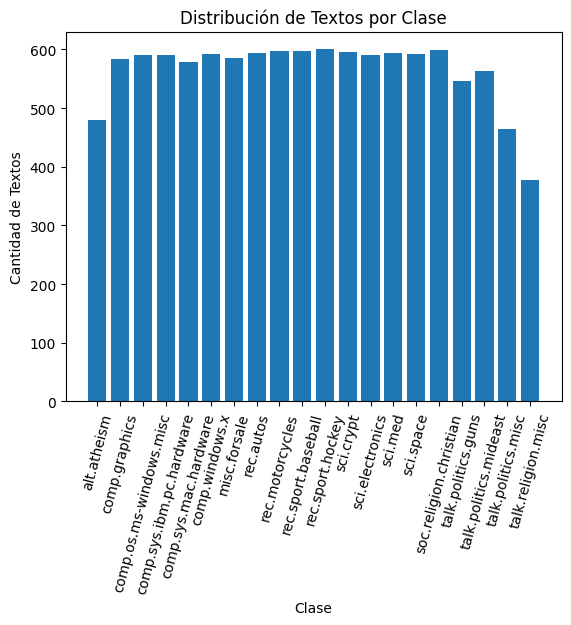

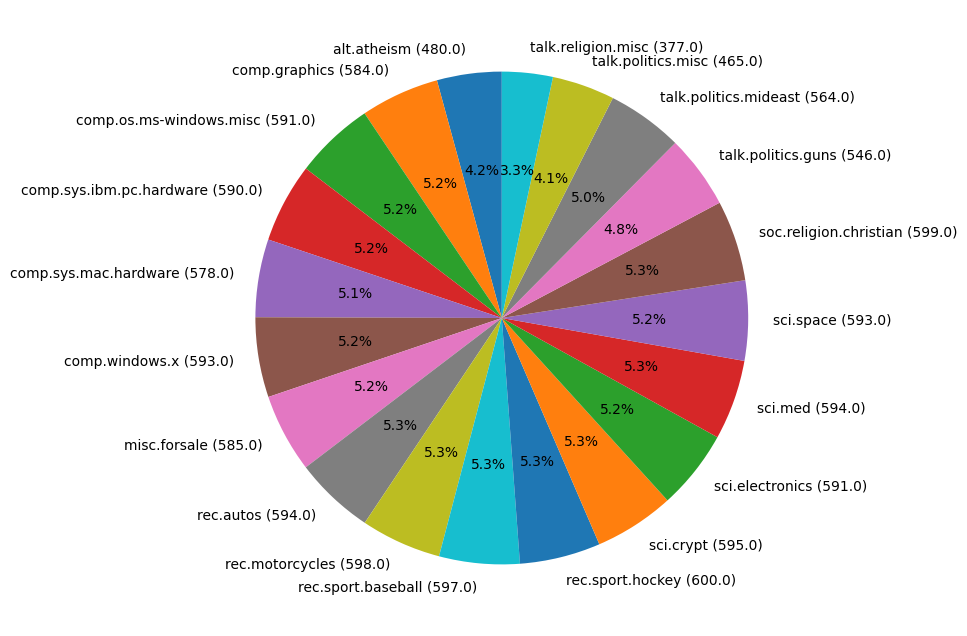

In [153]:
plt.bar(range(len(class_balance)), class_balance)
plt.xlabel('Clase')
plt.ylabel('Cantidad de Textos')
plt.title('Distribución de Textos por Clase')
plt.xticks(range(len(class_balance)), twenty_train.target_names, rotation=75)
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(class_balance_probs, labels=["{0} ({1})".format(twenty_train["target_names"][i], class_balance[i]) for i in range(len(twenty_train["target_names"]))], autopct="%1.1f%%", startangle=90)
plt.show()

#### <a id='toc1_2_1_2_'></a>[Frecuencias de palabras (raw)](#toc0_)

In [154]:
# vectorizer = CountVectorizer(stop_words="english") 
vectorizer = CountVectorizer() # Examinamos primero el dataset inmaculado, tal como viene (con los removes del fetch)
X_train = vectorizer.fit_transform(twenty_train.data)

In [155]:
print("Vocabulario:")
print(list(vectorizer.vocabulary_.items())[:10])
print("\nTamaño del Vocabulario:", len(vectorizer.vocabulary_))

Vocabulario:
[('was', 95844), ('wondering', 97181), ('if', 48754), ('anyone', 18915), ('out', 68847), ('there', 88638), ('could', 30074), ('enlighten', 37335), ('me', 60560), ('on', 68080)]

Tamaño del Vocabulario: 101631


In [156]:
# Recuento de palabras

unique_words_count = len(vectorizer.vocabulary_)
print(f"Número de palabras únicas: {unique_words_count}")

word_counts = np.sum(X_train.toarray(), axis=0)

total_words_count = np.sum(word_counts)
print(f"Número de palabras totales en el corpus: {total_words_count}")

Número de palabras únicas: 101631


Número de palabras totales en el corpus: 2158589


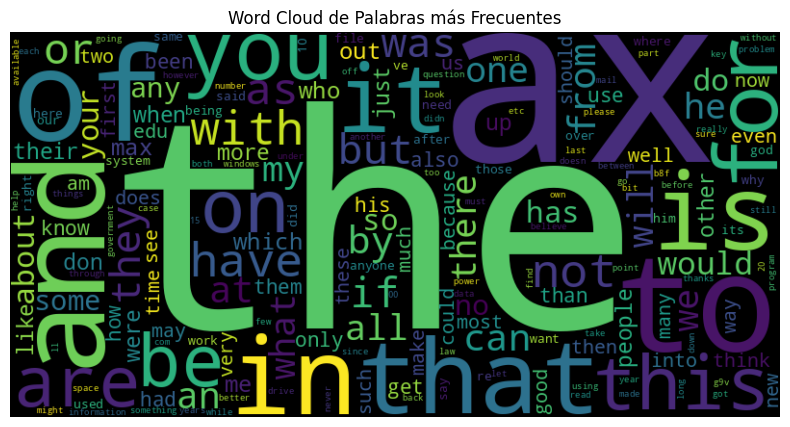

In [157]:
# Nube de palabras

word_freq = {word: count for word, count in zip(vectorizer.get_feature_names_out(), word_counts)}
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Palabras más Frecuentes')
plt.show()

Palabra más frecuente: 'the', frecuencia: 106381
Palabra más frecuente: 'ax', frecuencia: 62387
Palabra más frecuente: 'to', frecuencia: 53090
Palabra más frecuente: 'of', frecuencia: 46953
Palabra más frecuente: 'and', frecuencia: 42704
Palabra más frecuente: 'in', frecuencia: 31103
Palabra más frecuente: 'is', frecuencia: 30419
Palabra más frecuente: 'that', frecuencia: 27996
Palabra más frecuente: 'it', frecuencia: 23687
Palabra más frecuente: 'for', frecuencia: 19969
Palabra más frecuente: 'you', frecuencia: 18364
Palabra más frecuente: 'this', frecuencia: 14497
Palabra más frecuente: 'on', frecuencia: 14458
Palabra más frecuente: 'be', frecuencia: 13809
Palabra más frecuente: 'are', frecuencia: 13024
Palabra más frecuente: 'have', frecuencia: 12848
Palabra más frecuente: 'with', frecuencia: 12666
Palabra más frecuente: 'not', frecuencia: 12544
Palabra más frecuente: 'as', frecuencia: 11644
Palabra más frecuente: 'or', frecuencia: 10610


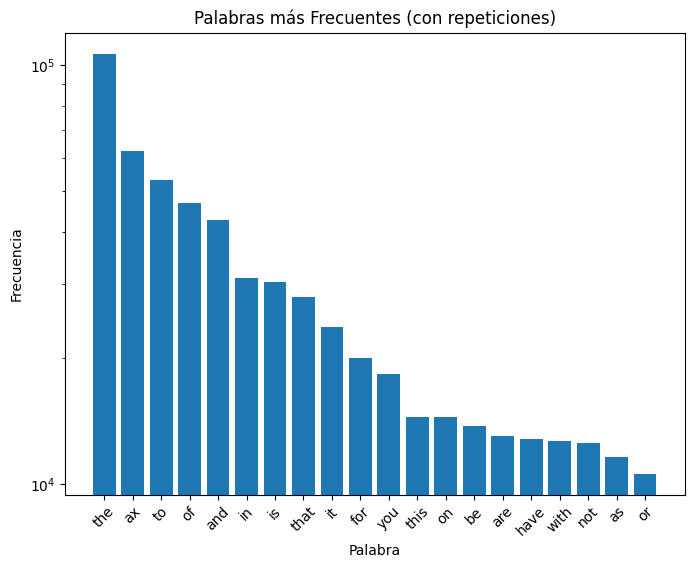

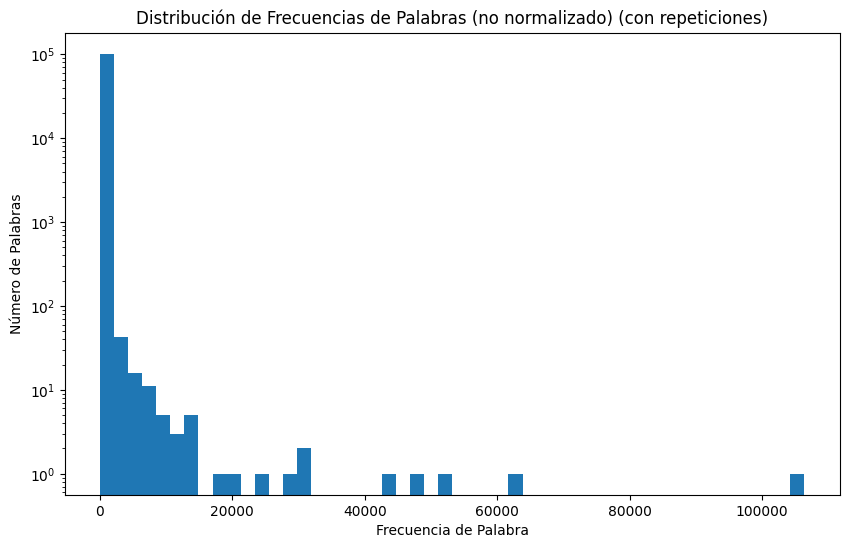

In [158]:
# Más frecuentes, con repeticiones

most_frequent_words = np.argsort(word_counts)[::-1][:20]
for i in most_frequent_words:
  print(f"Palabra más frecuente: '{vectorizer.get_feature_names_out()[i]}', frecuencia: {word_counts[i]}")
  
most_frequent_words_names = [vectorizer.get_feature_names_out()[i] for i in most_frequent_words]
most_frequent_words_counts = word_counts[most_frequent_words]

# Histograma de frecuencia de palabra según la palabra
plt.figure(figsize=(8, 6))
plt.bar(most_frequent_words_names, most_frequent_words_counts)
plt.xlabel("Palabra")
plt.xticks(rotation=45)
plt.ylabel("Frecuencia")
plt.yscale('log')
plt.title("Palabras más Frecuentes (con repeticiones)")
plt.show()

# Histograma de N° de palabras según su ocurrencia (no normalizado)
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, log=True)
plt.xlabel("Frecuencia de Palabra")
plt.ylabel("Número de Palabras")
plt.title("Distribución de Frecuencias de Palabras (no normalizado) (con repeticiones)")
plt.show()

Palabra: 'the'
Clase 'alt.atheism': 4551 ocurrencias
Clase 'comp.graphics': 3652 ocurrencias
Clase 'comp.os.ms-windows.misc': 2707 ocurrencias
Clase 'comp.sys.ibm.pc.hardware': 3658 ocurrencias
Clase 'comp.sys.mac.hardware': 3290 ocurrencias
Clase 'comp.windows.x': 6750 ocurrencias
Clase 'misc.forsale': 1488 ocurrencias
Clase 'rec.autos': 3663 ocurrencias
Clase 'rec.motorcycles': 3358 ocurrencias
Clase 'rec.sport.baseball': 3508 ocurrencias
Clase 'rec.sport.hockey': 5491 ocurrencias
Clase 'sci.crypt': 8980 ocurrencias
Clase 'sci.electronics': 4057 ocurrencias
Clase 'sci.med': 5174 ocurrencias
Clase 'sci.space': 6317 ocurrencias
Clase 'soc.religion.christian': 8723 ocurrencias
Clase 'talk.politics.guns': 6698 ocurrencias
Clase 'talk.politics.mideast': 12095 ocurrencias
Clase 'talk.politics.misc': 7582 ocurrencias
Clase 'talk.religion.misc': 4639 ocurrencias

Palabra: 'ax'
Clase 'alt.atheism': 0 ocurrencias
Clase 'comp.graphics': 1 ocurrencias
Clase 'comp.os.ms-windows.misc': 62375 ocurr

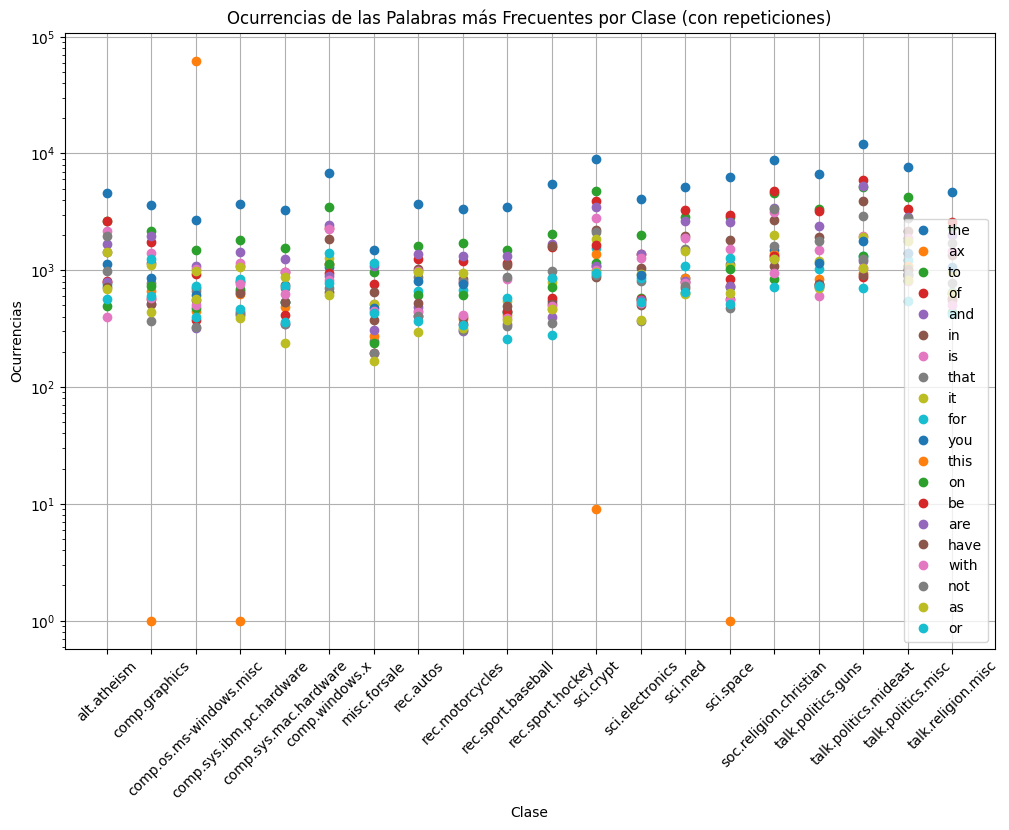

In [159]:
# Las más frecuentes globables vistas en cada clase (con repeticiones)

word_occurrences_by_class = {}

for word in most_frequent_words_names:
    word_index = vectorizer.vocabulary_.get(word)
    word_occurrences_by_class[word] = [np.sum(X_train[twenty_train.target == i, word_index]) for i in range(num_classes)]

# Prints
for word, occurrences in word_occurrences_by_class.items():
    print(f"Palabra: '{word}'")
    for i, occurrence in enumerate(occurrences):
        print(f"Clase '{twenty_train.target_names[i]}': {occurrence} ocurrencias")
    print()

# Plot
plt.figure(figsize=(12, 8))
for word, occurrences in word_occurrences_by_class.items():
    plt.plot(range(num_classes), occurrences, marker='o',  linestyle='None', label=word)

plt.xlabel("Clase")
plt.ylabel("Ocurrencias")
plt.yscale('log')
plt.title("Ocurrencias de las Palabras más Frecuentes por Clase (con repeticiones)")
plt.xticks(range(num_classes), twenty_train.target_names, rotation=45)
plt.legend()
plt.grid(True)
plt.show()


*El Document Frequency (DF) de una palabra es la proporción de documentos en los que aparece esa palabra dentro del corpus. Es decir, para cada palabra, el DF cuenta el número de documentos en los que aparece al menos una vez, sin contar las repeticiones dentro de un mismo documento.*

In [160]:
# df (document frequency) de cada palabra
df = np.sum(X_train, axis=0)

# Normalización del df
num_docs = X_train.shape[0]
df_normalized = df / num_docs

df_normalized = np.array(df_normalized).flatten()
df_normalized = (df_normalized - df_normalized.min()) / (df_normalized.max() - df_normalized.min())

# Mapeo cada palabra a su df
word_df = {word: df for word, df in zip(vectorizer.get_feature_names_out(), df_normalized)}
    
sorted_word_df = sorted(word_df.items(), key=lambda x: x[1], reverse=True)

# 20 palabras con el mayor df
top_words = sorted_word_df[:20]
for word, df in top_words:
    print(f"Palabra: {word}, Document Frequency: {df}")

Palabra: the, Document Frequency: 1.0
Palabra: ax, Document Frequency: 0.5864448204549727
Palabra: to, Document Frequency: 0.4990505734160557
Palabra: of, Document Frequency: 0.4413611581124272
Palabra: and, Document Frequency: 0.4014194397443129
Palabra: in, Document Frequency: 0.29236698627561575
Palabra: is, Document Frequency: 0.2859372062417748
Palabra: that, Document Frequency: 0.2631603684903177
Palabra: it, Document Frequency: 0.22265463432976124
Palabra: for, Document Frequency: 0.1877044557247603
Palabra: you, Document Frequency: 0.17261703327693173
Palabra: this, Document Frequency: 0.1362662154540327
Palabra: on, Document Frequency: 0.13589960518894528
Palabra: be, Document Frequency: 0.12979883436736228
Palabra: are, Document Frequency: 0.12241962774957699
Palabra: have, Document Frequency: 0.1207651814250799
Palabra: with, Document Frequency: 0.11905433352133858
Palabra: not, Document Frequency: 0.11790750141003947
Palabra: as, Document Frequency: 0.10944726452340664
Pala

Si bien no hemos tokenizado todavía, del histograma de DFs podemos ya visualizar hacer un barrido de `max_df` hasta no mucho más que 0.3, mientras que para `min_df` se analizaran valores bajos.

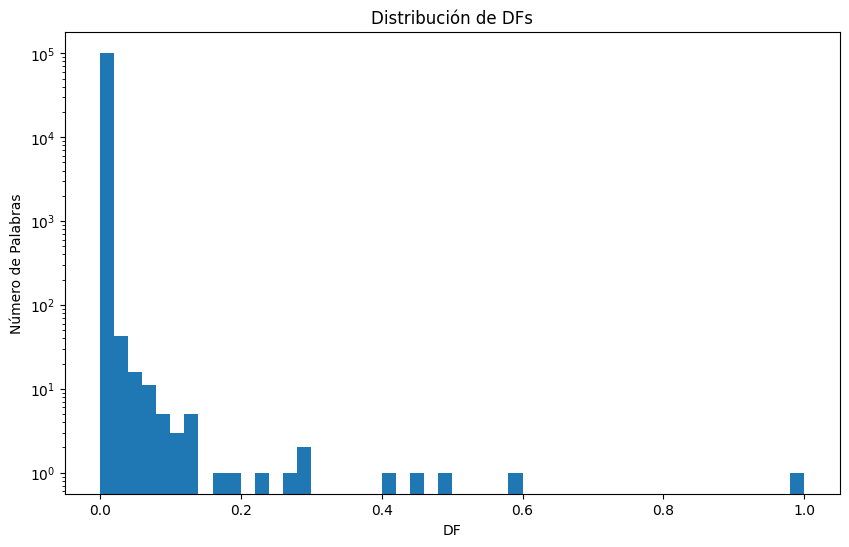

In [161]:
# Histograma df
plt.figure(figsize=(10, 6))
plt.hist(df_normalized, bins=50, log=True)
plt.xlabel("DF")
plt.ylabel("Número de Palabras")
plt.yscale('log')
plt.title("Distribución de DFs")
plt.show()

In [162]:
# Menos frecuentes

least_frequent_words = np.argsort(word_counts)[:20]
for i in least_frequent_words:
  print(f"Palabra menos frecuente: '{vectorizer.get_feature_names_out()[i]}', frecuencia: {word_counts[i]}")

Palabra menos frecuente: 'ýé', frecuencia: 1
Palabra menos frecuente: 'leakages', frecuencia: 1
Palabra menos frecuente: 'leaked', frecuencia: 1
Palabra menos frecuente: 'leanna', frecuencia: 1
Palabra menos frecuente: 'leao', frecuencia: 1
Palabra menos frecuente: 'leapard', frecuencia: 1
Palabra menos frecuente: 'leaped', frecuencia: 1
Palabra menos frecuente: 'leapfrog', frecuencia: 1
Palabra menos frecuente: 'lear', frecuencia: 1
Palabra menos frecuente: 'learjet', frecuencia: 1
Palabra menos frecuente: 'yha', frecuencia: 1
Palabra menos frecuente: 'learnd', frecuencia: 1
Palabra menos frecuente: 'yh8', frecuencia: 1
Palabra menos frecuente: 'leased', frecuencia: 1
Palabra menos frecuente: 'leashed', frecuencia: 1
Palabra menos frecuente: 'yhah', frecuencia: 1
Palabra menos frecuente: 'leatherette', frecuencia: 1
Palabra menos frecuente: 'yguo', frecuencia: 1
Palabra menos frecuente: 'leaven', frecuencia: 1
Palabra menos frecuente: 'leavening', frecuencia: 1


#### <a id='toc1_2_1_3_'></a>[Longitudes (raw)](#toc0_)


Longitud mínima de texto: 0
Longitud máxima de texto: 11765
Longitud promedio de texto: 185.82738200459607
Longitud mediana de texto: 83.0



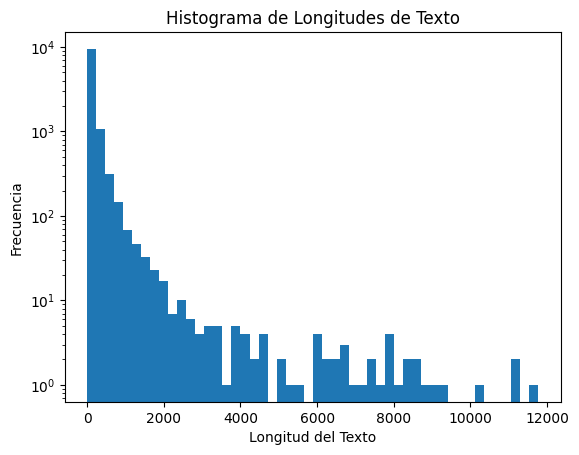

In [163]:
# Longitudes de los textos
text_lengths = [len(text.split()) for text in twenty_train.data]
print(f"\nLongitud mínima de texto: {min(text_lengths)}")
print(f"Longitud máxima de texto: {max(text_lengths)}")
print(f"Longitud promedio de texto: {np.mean(text_lengths)}")
print(f"Longitud mediana de texto: {np.median(text_lengths)}\n")

# Histograma de Longitudes de Texto
text_lengths = [len(text.split()) for text in twenty_train.data]
plt.hist(text_lengths, bins=50)
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.title('Histograma de Longitudes de Texto')
plt.yscale('log')
plt.show()

Longitud promedio por clase:
Clase 'alt.atheism': 194.39
Clase 'comp.graphics': 157.81
Clase 'comp.os.ms-windows.misc': 132.99
Clase 'comp.sys.ibm.pc.hardware': 131.79
Clase 'comp.sys.mac.hardware': 109.26
Clase 'comp.windows.x': 238.04
Clase 'misc.forsale': 104.34
Clase 'rec.autos': 116.35
Clase 'rec.motorcycles': 107.77
Clase 'rec.sport.baseball': 121.14
Clase 'rec.sport.hockey': 201.87
Clase 'sci.crypt': 275.10
Clase 'sci.electronics': 129.93
Clase 'sci.med': 197.82
Clase 'sci.space': 202.32
Clase 'soc.religion.christian': 262.76
Clase 'talk.politics.guns': 215.72
Clase 'talk.politics.mideast': 350.43
Clase 'talk.politics.misc': 286.87
Clase 'talk.religion.misc': 223.12


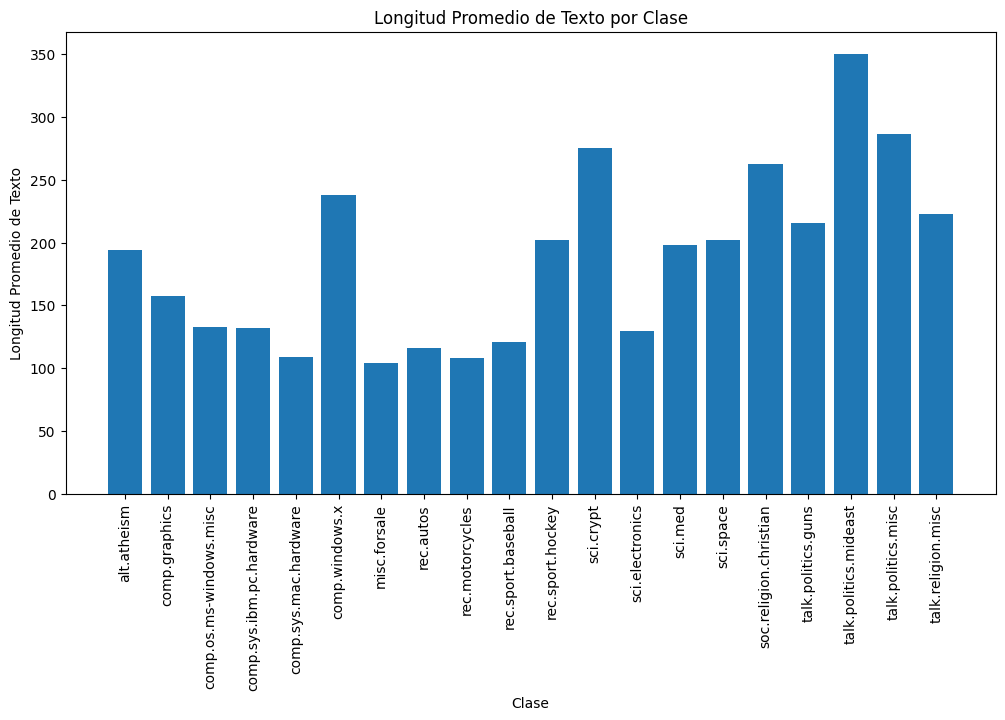

In [164]:
# Longitudes de texto por clase
class_text_lengths = []
for i in range(len(twenty_train.target_names)):
    text_indices = np.where(twenty_train.target == i)[0]
    class_texts = [len(twenty_train.data[idx].split()) for idx in text_indices]
    class_text_lengths.append(np.mean(class_texts))

print("Longitud promedio por clase:")
for i, class_name in enumerate(twenty_train.target_names):
    print(f"Clase '{class_name}': {class_text_lengths[i]:.2f}")

# Histograma de longitudes de texto por clase
plt.figure(figsize=(12, 6))
plt.bar(twenty_train.target_names, class_text_lengths)
plt.xlabel('Clase')
plt.ylabel('Longitud Promedio de Texto')
plt.title('Longitud Promedio de Texto por Clase')
plt.xticks(rotation=90)
plt.show()

### <a id='toc1_2_2_'></a>[Métrica](#toc0_)

Se decide usar el `accuracy` (presición) como métrica.

* Interpretación: representa la proporción de predicciones correctas sobre el total de predicciones realizadas. Significado *relevante* en un problema de clasificación.
* Equilibrio de clases: al observarse que las clases están balanceadas (aprox. 5% de ocurrencia cada una de las 20), cada una "aporta lo mismo" al cálculo del accuracy.

### <a id='toc1_2_3_'></a>[Preprocessing de la data](#toc0_)

Vamos a tokenizar, lematizar, stemizar, sacar stopwords y números (no-letras) del corpus original.

Evaluamos combinaciones entre estas técnicas de tokenización para ver en cuáles se obtenía mejor score.

![proofs](https://i.imgur.com/YP8WkpT.png)

In [165]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_article(article):
    tok = word_tokenize(article)
    lem = [lemmatizer.lemmatize(x, pos='v') for x in tok]
    stop = [x for x in lem if x not in stopwords.words('english')]
    stem = [stemmer.stem(x) for x in stop]
    alpha = [x for x in stem if x.isalpha()]
    return " ".join(alpha)

# def preprocess_article(article):
#     tok = word_tokenize(article)
#     lem = [lemmatizer.lemmatize(x, pos='v') for x in tok]
#     stop = [x for x in lem if x not in stopwords.words('english')]
#     alpha = [x for x in stop if x.isalpha()]
#     return " ".join(alpha)

#### <a id='toc1_2_3_1_'></a>[Archivos](#toc0_)

Se guardan a disco los preprocesamientos de train y test, para levantarlos más rápidamente en otras ejecuciones, siempre que no se haya modificado el esquema de tokenización.

In [166]:
train_data = list()
test_data = list()

train_file_exists = os.path.exists('art_filt_train.txt')
test_file_exists = os.path.exists('art_filt_test.txt')

print("train: ", train_file_exists, "||| test: ", test_file_exists)

# Si los archivos existen, cargar los datos desde los archivos
if train_file_exists:
    with open('art_filt_train.txt', 'rb') as fp:
        train_data = pickle.load(fp)
        
    print("Datos de entrenamiento cargados desde el archivo")
    
# Si no existen, los proceso desde twenty y guardo en archivo
else:   
    for i in tqdm(range(len(twenty_train.data))):
        art = twenty_train.data[i]
        filtered_article = preprocess_article(art)
        train_data.append(filtered_article)
        
    print("Datos de entrenamiento procesados")
    
    with open('art_filt_train.txt', 'wb') as fp:
        pickle.dump(train_data, fp)
        
    print("Datos de entrenamiento guardados en el archivo")

if test_file_exists:
    with open('art_filt_test.txt', 'rb') as fp:
        test_data = pickle.load(fp)
        
    print("Datos de prueba cargados desde el archivo")
else:    
    for i in tqdm(range(len(twenty_test.data))):
        art = twenty_test.data[i]
        filtered_article = preprocess_article(art)
        test_data.append(filtered_article)
        
    print("Datos de prueba procesados")
    
    with open('art_filt_test.txt', 'wb') as fp:
        pickle.dump(test_data, fp)
        
    print("Datos de prueba guardados en el archivo")

train:  True ||| test:  True
Datos de entrenamiento cargados desde el archivo
Datos de prueba cargados desde el archivo


In [167]:
# Forzar guardado o lectura

# import pickle

# with open('art_filt_train.txt', 'wb') as fp:
#     pickle.dump(train_filt, fp)
    
# with open('art_filt_test.txt', 'wb') as fp:
#     pickle.dump(test_filt, fp)
    
# with open ('art_filt_train.txt', 'rb') as fp:
#   train_data = pickle.load(fp)
  
# with open ('art_filt_test.txt', 'rb') as fp:
#   test_data = pickle.load(fp)

### <a id='toc1_2_4_'></a>[EDA_v2](#toc0_)

Repetimos algunas de las estadísticas/plots del EDA ya realizado, para evaluar cómo quedó reorganizado el dataset de train luego de la tokenización.

In [168]:
vectorizer_tok = CountVectorizer()
X_train_tok = vectorizer_tok.fit_transform(train_data)

In [169]:
print("Vocabulario:")
print(list(vectorizer_tok.vocabulary_.items())[:10])
print("\nTamaño del Vocabulario:", len(vectorizer_tok.vocabulary_))

Vocabulario:
[('wonder', 42579), ('anyon', 1649), ('could', 7745), ('enlighten', 11445), ('car', 5455), ('saw', 33586), ('day', 8681), ('it', 18794), ('sport', 35920), ('look', 22012)]

Tamaño del Vocabulario: 44610


In [170]:
# Recuento de palabras

unique_words_count_tok = len(vectorizer_tok.vocabulary_)
print(f"Número de palabras únicas: {unique_words_count_tok}")

word_counts_tok = np.sum(X_train_tok.toarray(), axis=0)

total_words_count_tok = np.sum(word_counts_tok)
print(f"Número de palabras totales en el corpus: {total_words_count_tok}")

Número de palabras únicas: 44610


Número de palabras totales en el corpus: 1104900


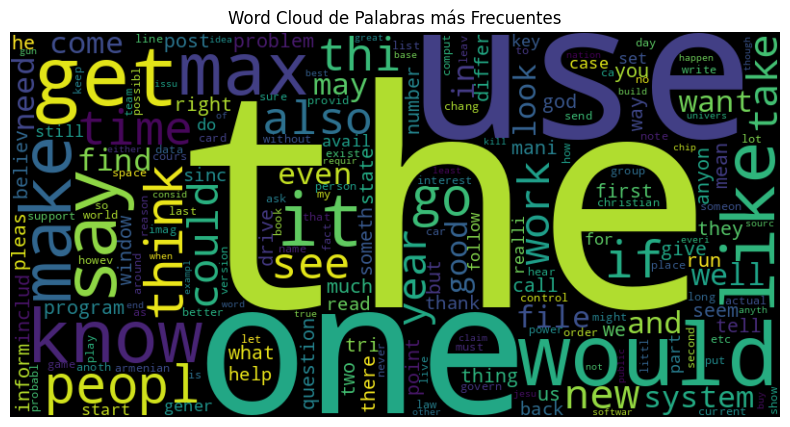

In [171]:
# Nube de palabras

word_freq_tok = {word: count for word, count in zip(vectorizer_tok.get_feature_names_out(), word_counts_tok)}
wordcloud_tok = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_tok)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tok, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Palabras más Frecuentes')
plt.show()

Palabra más frecuente: 'the', frecuencia: 11558
Palabra más frecuente: 'use', frecuencia: 7160
Palabra más frecuente: 'one', frecuencia: 6602
Palabra más frecuente: 'would', frecuencia: 6539
Palabra más frecuente: 'get', frecuencia: 5754
Palabra más frecuente: 'say', frecuencia: 4764
Palabra más frecuente: 'know', frecuencia: 4563
Palabra más frecuente: 'max', frecuencia: 4550
Palabra más frecuente: 'it', frecuencia: 4541
Palabra más frecuente: 'like', frecuencia: 4418
Palabra más frecuente: 'make', frecuencia: 4194
Palabra más frecuente: 'peopl', frecuencia: 4113
Palabra más frecuente: 'think', frecuencia: 4045
Palabra más frecuente: 'go', frecuencia: 4029
Palabra más frecuente: 'if', frecuencia: 3790
Palabra más frecuente: 'time', frecuencia: 3565
Palabra más frecuente: 'also', frecuencia: 3348
Palabra más frecuente: 'thi', frecuencia: 3315
Palabra más frecuente: 'see', frecuencia: 3019
Palabra más frecuente: 'work', frecuencia: 2888


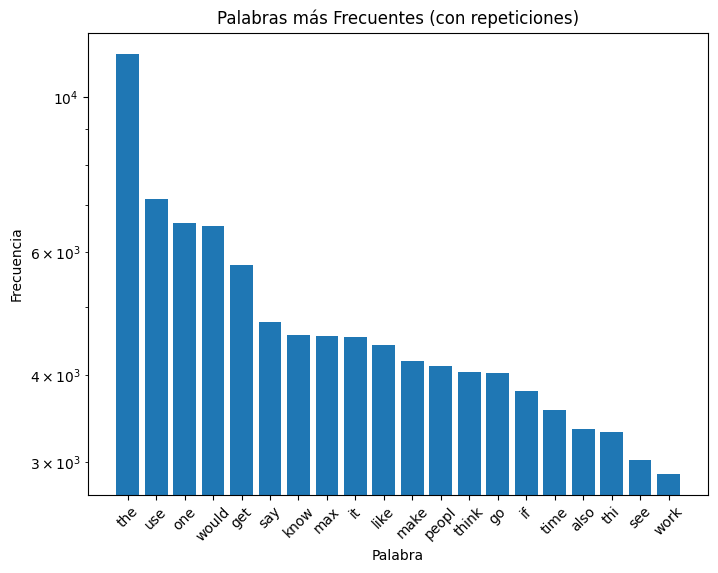

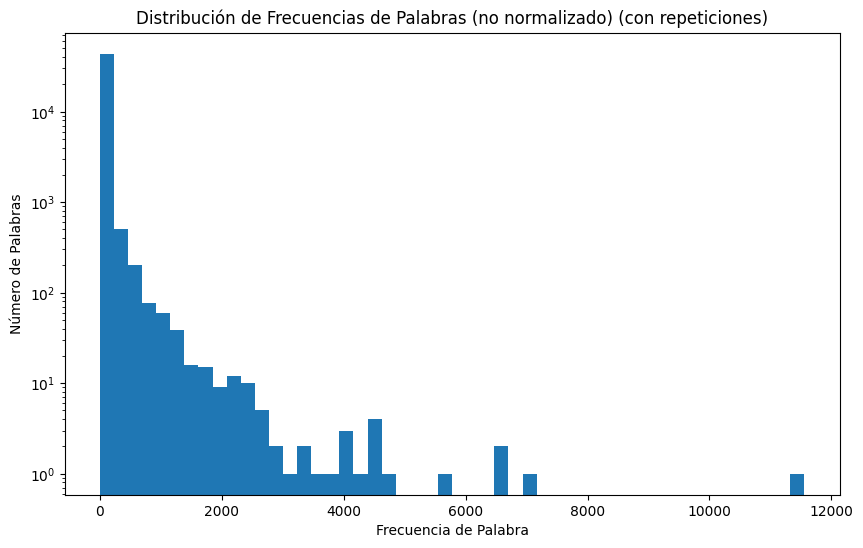

In [172]:
# Más frecuentes, con repeticiones

most_frequent_words_tok = np.argsort(word_counts_tok)[::-1][:20]
for i in most_frequent_words_tok:
  print(f"Palabra más frecuente: '{vectorizer_tok.get_feature_names_out()[i]}', frecuencia: {word_counts_tok[i]}")
  
most_frequent_words_names_tok = [vectorizer_tok.get_feature_names_out()[i] for i in most_frequent_words_tok]
most_frequent_words_counts_tok = word_counts_tok[most_frequent_words_tok]

# Histograma de frecuencia de palabra según la palabra
plt.figure(figsize=(8, 6))
plt.bar(most_frequent_words_names_tok, most_frequent_words_counts_tok)
plt.xlabel("Palabra")
plt.xticks(rotation=45)
plt.ylabel("Frecuencia")
plt.yscale('log')
plt.title("Palabras más Frecuentes (con repeticiones)")
plt.show()

# Histograma de N° de palabras según su ocurrencia (no normalizado)
plt.figure(figsize=(10, 6))
plt.hist(word_counts_tok, bins=50, log=True)
plt.xlabel("Frecuencia de Palabra")
plt.ylabel("Número de Palabras")
plt.title("Distribución de Frecuencias de Palabras (no normalizado) (con repeticiones)")
plt.show()

Palabra: 'the'
Clase 'alt.atheism': 448 ocurrencias
Clase 'comp.graphics': 500 ocurrencias
Clase 'comp.os.ms-windows.misc': 280 ocurrencias
Clase 'comp.sys.ibm.pc.hardware': 373 ocurrencias
Clase 'comp.sys.mac.hardware': 303 ocurrencias
Clase 'comp.windows.x': 805 ocurrencias
Clase 'misc.forsale': 249 ocurrencias
Clase 'rec.autos': 355 ocurrencias
Clase 'rec.motorcycles': 300 ocurrencias
Clase 'rec.sport.baseball': 335 ocurrencias
Clase 'rec.sport.hockey': 561 ocurrencias
Clase 'sci.crypt': 1028 ocurrencias
Clase 'sci.electronics': 454 ocurrencias
Clase 'sci.med': 612 ocurrencias
Clase 'sci.space': 873 ocurrencias
Clase 'soc.religion.christian': 813 ocurrencias
Clase 'talk.politics.guns': 868 ocurrencias
Clase 'talk.politics.mideast': 1194 ocurrencias
Clase 'talk.politics.misc': 760 ocurrencias
Clase 'talk.religion.misc': 447 ocurrencias

Palabra: 'use'
Clase 'alt.atheism': 176 ocurrencias
Clase 'comp.graphics': 509 ocurrencias
Clase 'comp.os.ms-windows.misc': 497 ocurrencias
Clase 'co

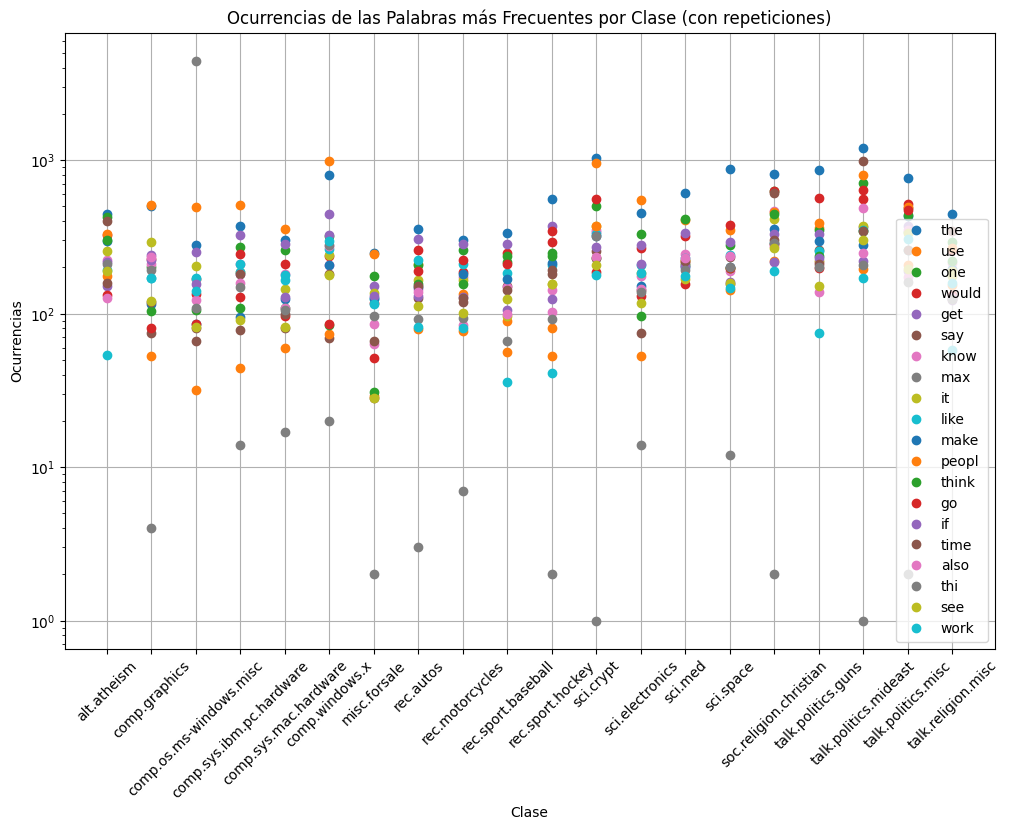

In [173]:
# Las más frecuentes globables vistas en cada clase (con repeticiones)

word_occurrences_by_class_tok = {}

for word in most_frequent_words_names_tok:
    word_index_tok = vectorizer_tok.vocabulary_.get(word)
    word_occurrences_by_class_tok[word] = [np.sum(X_train_tok[twenty_train.target == i, word_index_tok]) for i in range(num_classes)]

# Prints
for word, occurrences in word_occurrences_by_class_tok.items():
    print(f"Palabra: '{word}'")
    for i, occurrence in enumerate(occurrences):
        print(f"Clase '{twenty_train.target_names[i]}': {occurrence} ocurrencias")
    print()

# Plot
plt.figure(figsize=(12, 8))
for word, occurrences in word_occurrences_by_class_tok.items():
    plt.plot(range(num_classes), occurrences, marker='o',  linestyle='None', label=word)

plt.xlabel("Clase")
plt.ylabel("Ocurrencias")
plt.yscale('log')
plt.title("Ocurrencias de las Palabras más Frecuentes por Clase (con repeticiones)")
plt.xticks(range(num_classes), twenty_train.target_names, rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [174]:
# df (document frequency) de cada palabra
df_tok = np.sum(X_train_tok, axis=0)

# Normalización del df
num_docs_tok = X_train_tok.shape[0]
df_normalized_tok = df_tok / num_docs_tok

df_normalized_tok = np.array(df_normalized_tok).flatten()
df_normalized_tok = (df_normalized_tok - df_normalized_tok.min()) / (df_normalized_tok.max() - df_normalized_tok.min())

# Mapeo cada palabra a su df
word_df_tok = {word: df_tok for word, df_tok in zip(vectorizer_tok.get_feature_names_out(), df_normalized_tok)}
    
sorted_word_df_tok = sorted(word_df_tok.items(), key=lambda x: x[1], reverse=True)

# 20 palabras con el mayor df
top_words_tok = sorted_word_df_tok[:20]
for word, df in top_words_tok:
    print(f"Palabra: {word}, Document Frequency: {df}")

Palabra: the, Document Frequency: 1.0
Palabra: use, Document Frequency: 0.6194514147270053
Palabra: one, Document Frequency: 0.5711689884918231
Palabra: would, Document Frequency: 0.565717746820109
Palabra: get, Document Frequency: 0.49779354503763956
Palabra: say, Document Frequency: 0.4121311759107035
Palabra: know, Document Frequency: 0.39473911914856796
Palabra: max, Document Frequency: 0.39361425975599207
Palabra: it, Document Frequency: 0.39283551094574715
Palabra: like, Document Frequency: 0.3821926105390672
Palabra: make, Document Frequency: 0.3628104179285282
Palabra: peopl, Document Frequency: 0.3558016786363243
Palabra: think, Document Frequency: 0.3499177987366964
Palabra: go, Document Frequency: 0.34853335640737215
Palabra: if, Document Frequency: 0.3278532491130916
Palabra: time, Document Frequency: 0.3083845288569698
Palabra: also, Document Frequency: 0.28960802976551003
Palabra: thi, Document Frequency: 0.28675261746127884
Palabra: see, Document Frequency: 0.26114043436

Ya habiendo tokenizado, un rango de `max_df` a analizar podría ser de 0.05 a 0.3.

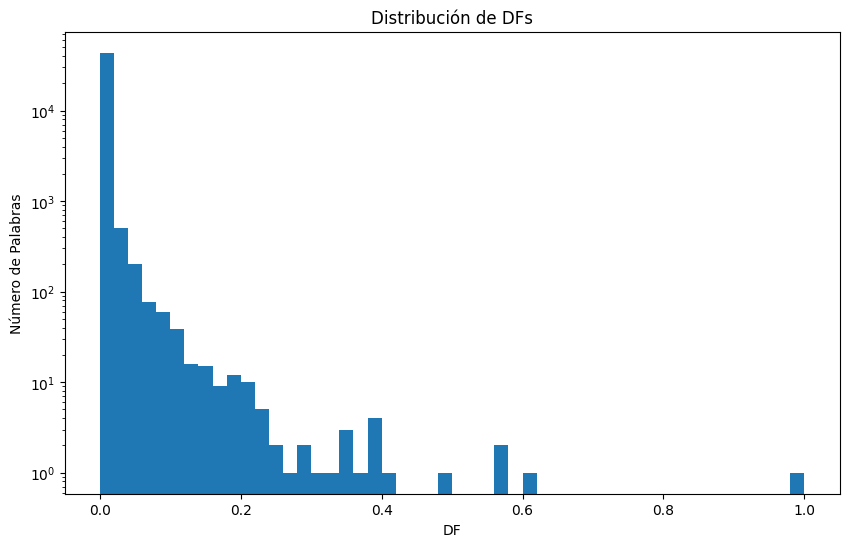

In [175]:
# Histograma df
plt.figure(figsize=(10, 6))
plt.hist(df_normalized_tok, bins=50, log=True)
plt.xlabel("DF")
plt.ylabel("Número de Palabras")
plt.yscale('log')
plt.title("Distribución de DFs")
plt.show()

#### <a id='toc1_2_4_1_'></a>[Vocabulario vs mindf vs maxdf](#toc0_)

Aplicamos combinaciones entre `min_df` y `max_df` para evaluar su impacto en la longitud del vocabulario resulante.

In [176]:
# Define the range of max_df values
max_df_values = np.arange(0.01, 0.3, 0.02)

# Initialize a list to store vocabulary sizes for each max_df value
vocab_sizes_list = []

file_name = 'vocab_sizes_list.pkl'

# Comprobar si el archivo ya existe
if os.path.exists(file_name):
    with open(file_name, 'rb') as f:
        vocab_sizes_list = pickle.load(f)
        
else:
    # Define the range of max_df values
    max_df_values = np.arange(0.01, 0.3, 0.02)

    # Initialize a list to store vocabulary sizes for each max_df value
    vocab_sizes_list = []

    # Iterate over max_df values
    for max_df in max_df_values:
        vocab_sizes = []
        for min_df in range(8, 15):
            vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=(1, 1))
            X = vectorizer.fit_transform(train_data)
            vocab_sizes.append(len(vectorizer.vocabulary_))
        vocab_sizes_list.append(vocab_sizes)

    # Guardar vocab_sizes_list en el archivo
    with open(file_name, 'wb') as f:
        pickle.dump(vocab_sizes_list, f)


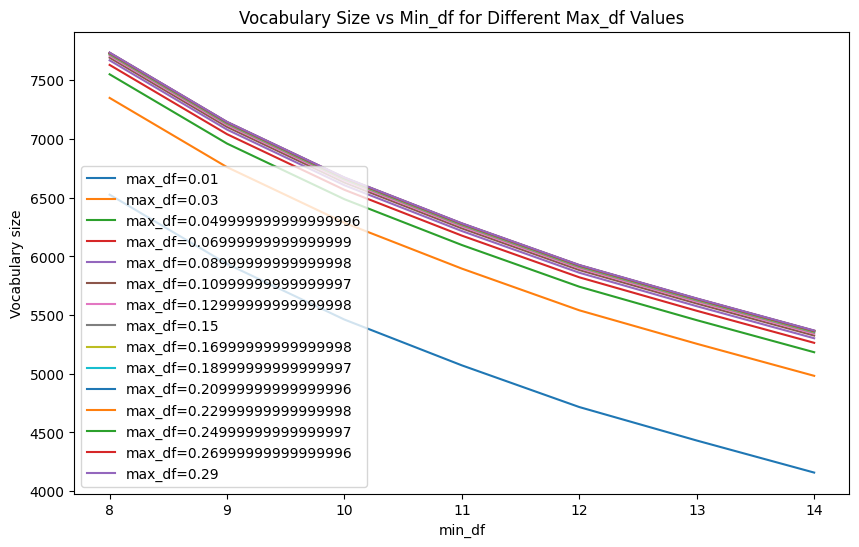

In [177]:
# Plot the vocabulary size vs min_df for each max_df value
plt.figure(figsize=(10, 6))
for i, max_df in enumerate(max_df_values):
    plt.plot(range(8, 15), vocab_sizes_list[i], label=f'max_df={max_df}')

plt.xlabel("min_df")
plt.ylabel("Vocabulary size")
plt.title("Vocabulary Size vs Min_df for Different Max_df Values")
plt.legend()
plt.show()


In [178]:
vocab_sizes = []
for max_df in np.arange(0.01, 0.35, 0.02):
  vectorizer = CountVectorizer(max_df=max_df,min_df=8, ngram_range=(1, 1))
  X = vectorizer.fit_transform(train_data)
  vocab_sizes.append(vectorizer.vocabulary_.__len__())

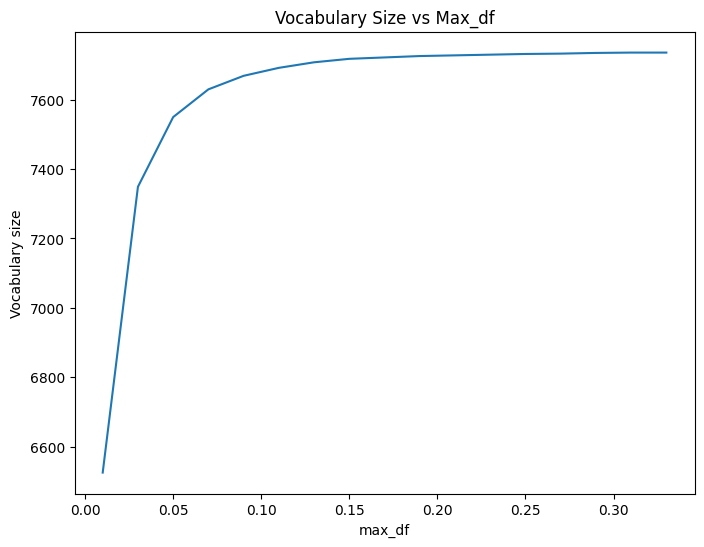

In [179]:
# Plot the vocabulary size vs max_df
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0.01, 0.35, 0.02), vocab_sizes)
plt.xlabel("max_df")
plt.ylabel("Vocabulary size")
plt.title("Vocabulary Size vs Max_df")
plt.show()

### <a id='toc1_2_5_'></a>[Train](#toc0_)

#### <a id='toc1_2_5_1_'></a>[Pipeline & Hyperparameters & GridSearch](#toc0_)

Planteamos entrenar 3 modelos:
1. MultinomialNB
2. LogisticRegression
3. SGDClassifier

Cada uno lo encapsulamos en un pipeline junto a la vectorización por CountVectorizer y a la ponderación por TFIDF, para luego buscar hiperparámetros óptimos para cada combinación a través de GridSearchCV.

El GridSearchCV se ejecuta con el argumento `cv=2`, por lo que el dataset usado para entrenar (`train_data`) es partido en dos para hacer cross-validation.

Presentamos luego los scores obtenidos para cada combinación de hiperparámetros evaluada en cada modelo, resaltando la combinación óptima en cada caso y comparándolas.

Respecto al barrido de hiperparámetros propuesto:
* `max_df` y `min_df` surgen desde la distribución de DFs y de evaluar la longitud del vocabulario en función de ellos.
* Usar TFIDF dio mejores resultados que no usarlos.

> Terminamos no entrenando RandomForestClassifier por excesivos tiempos de cómputo.

In [180]:
pipeline_basic = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

# grid_basic = {
#     'pipeline_basic__vect__max_df': (0.1, 0.2, 0.3, 0.4),
#     'pipeline_basic__vect__min_df': (4, 6, 8, 10),
#     'pipeline_basic__vect__ngram_range': ((1, 1)),
#     'pipeline_basic__tfidf__use_idf': True
# }
grid_basic = {
    'pipeline_basic__vect__stop_words': ["english"],
    'pipeline_basic__vect__max_df': np.arange(0.1, 0.25, 0.02),
    'pipeline_basic__vect__min_df': np.arange(1, 8, 2),
    'pipeline_basic__vect__ngram_range': [(1, 1), (1, 2)],
    'pipeline_basic__tfidf__use_idf': [True]
}

pipeline_mnb = Pipeline([
    ('pipeline_basic', pipeline_basic),
    ('mnb', MultinomialNB()),
])

grid_mnb = {
    'mnb__alpha': [0.001, 0.01, 0.1]
}
grid_mnb.update(grid_basic)

pipeline_lr = Pipeline([
    ('pipeline_basic', pipeline_basic),
    ('lr', LogisticRegression())
])

grid_lr= {
    'lr__C': [0.1, 1, 10],
    'lr__max_iter': [1000],
    # 'lr__penalty': ('l1', 'l2'),
    # 'lr__solver': ('lbfgs', 'sag'),
    'lr__solver': ['sag'],
}
grid_lr.update(grid_basic)

pipeline_sgd = Pipeline([
    ('pipeline_basic', pipeline_basic),
    ('sgd', SGDClassifier()),
])

grid_sgd= {
    # 'sgd__loss': ('hinge', 'log'),
    'sgd__alpha': [0.001, 0.01, 0.1],
    # 'sgd__penalty': ('l1', 'l2')
}
grid_sgd.update(grid_basic)

# pipeline_rf= Pipeline([
#     ('pipeline_basic', pipeline_basic),
#     ('rf', RandomForestClassifier()),
# ])

# grid_rf= {
#     'rf__n_estimators': (10, 50, 100),
#     # 'rf__max_depth': (3, 5, 10, None),
#     # 'rf__min_samples_leaf': (1, 2, 3),
#     # 'rf__min_samples_split': (1, 2, 3),
# }
# grid_rf.update(grid_basic)

models = [("MultinomialNB", pipeline_mnb, grid_mnb, "mnb")]
models.extend([
    ("LogisticRegression", pipeline_lr, grid_lr, "lr"),
    ("SGDClassifier", pipeline_sgd, grid_sgd, "sgd"),
    # ("RandomForestClassifier", pipeline_rf, grid_rf, "rf"),
])

for name, model, grid, short_name in models:
    print(name)
    print(model)
    print(grid)
    print(short_name)
    print("\n")

MultinomialNB
Pipeline(steps=[('pipeline_basic',
                 Pipeline(steps=[('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('mnb', MultinomialNB())])
{'mnb__alpha': [0.001, 0.01, 0.1], 'pipeline_basic__vect__stop_words': ['english'], 'pipeline_basic__vect__max_df': array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24]), 'pipeline_basic__vect__min_df': array([1, 3, 5, 7]), 'pipeline_basic__vect__ngram_range': [(1, 1), (1, 2)], 'pipeline_basic__tfidf__use_idf': [True]}
mnb


LogisticRegression
Pipeline(steps=[('pipeline_basic',
                 Pipeline(steps=[('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('lr', LogisticRegression())])
{'lr__C': [0.1, 1, 10], 'lr__max_iter': [1000], 'lr__solver': ['sag'], 'pipeline_basic__vect__stop_words': ['english'], 'pipeline_basic__vect__max_df': array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24]), 'pipeline_b

In [181]:
# Iteración de GridSeach para cada pipeline (para cada modelo).

for name, pipeline, grid, short_name in models:
    result_file = f"grid_{short_name}.pkl"
    if not os.path.exists(result_file):
        print(f"** Grid Search for {name} **\n")
        grid_search = GridSearchCV(pipeline, grid, n_jobs=-1, verbose=10, cv=2)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        print(grid)
        t0 = time()
        grid_search.fit(train_data, twenty_train.target)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(grid.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
            
        # Save results to file
        with open(result_file, 'wb') as fp:
            pickle.dump(grid_search, fp)
    else:
        print(f"Skipping GridSearch for {name} - results already present in file {result_file}")

Skipping GridSearch for MultinomialNB - results already present in file grid_mnb.pkl
Skipping GridSearch for LogisticRegression - results already present in file grid_lr.pkl
Skipping GridSearch for SGDClassifier - results already present in file grid_sgd.pkl


![Proofs](https://i.imgur.com/233ZCEi.png)

In [182]:
# # Entrenamiento manual por modelo

# name, pipeline, grid, short_name = models[2]

# result_file = f"grid_{short_name}.pkl"
# if not os.path.exists(result_file):
#     print(f"** Grid Search for {name} **\n")
#     grid_search = GridSearchCV(pipeline, grid, n_jobs=-1, verbose=10, cv=3)

#     print("Performing grid search...")
#     print("pipeline:", [name for name, _ in pipeline.steps])
#     print("parameters:")
#     print(grid)
#     t0 = time()
#     grid_search.fit(train_data, twenty_train.target)
#     print("done in %0.3fs" % (time() - t0))
#     print()

#     print("Best score: %0.3f" % grid_search.best_score_)
#     print("Best parameters set:")
#     best_parameters = grid_search.best_estimator_.get_params()
#     for param_name in sorted(grid.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

#     # Save results to file
#     with open(result_file, 'wb') as fp:
#         pickle.dump(grid_search, fp)
# else:
#     print(f"Skipping GridSearch for {name} - results already present in file {result_file}")

In [183]:
all_scores = {}
best_scores_and_params = {}

for name, pipeline, grid, short_name in models:
    result_file = f"grid_{short_name}.pkl"
    with open(result_file, 'rb') as fp:
        grid_search_data = pickle.load(fp)

    print(f"Grid scores for {name}: ({len(grid_search_data.cv_results_['mean_test_score'])} runs)\n")
    scores = []
    for mean, params in zip(grid_search_data.cv_results_['mean_test_score'],  grid_search_data.cv_results_['params']):
        print("%0.3f for %r" % (mean, params))
        scores.append(mean)
        
    all_scores[name] = scores   
        
    best_index = np.argmax(grid_search_data.cv_results_['mean_test_score'])
    best_score = grid_search_data.cv_results_['mean_test_score'][best_index]
    best_params = grid_search_data.cv_results_['params'][best_index]
    best_scores_and_params[name] = {"best_score": best_score, "best_params": best_params}
        
    print()
    print()

Grid scores for MultinomialNB: (192 runs)

0.710 for {'mnb__alpha': 0.001, 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 1, 'pipeline_basic__vect__ngram_range': (1, 1), 'pipeline_basic__vect__stop_words': 'english'}
0.722 for {'mnb__alpha': 0.001, 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 1, 'pipeline_basic__vect__ngram_range': (1, 2), 'pipeline_basic__vect__stop_words': 'english'}
0.687 for {'mnb__alpha': 0.001, 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 3, 'pipeline_basic__vect__ngram_range': (1, 1), 'pipeline_basic__vect__stop_words': 'english'}
0.688 for {'mnb__alpha': 0.001, 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 3, 'pipeline_basic__vect__ngram_range': (1, 2), 'pipeline_basic__vect__stop_words': 'english'}
0.676 for {'m

Grid scores for LogisticRegression: (192 runs)

0.644 for {'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__solver': 'sag', 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 1, 'pipeline_basic__vect__ngram_range': (1, 1), 'pipeline_basic__vect__stop_words': 'english'}
0.628 for {'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__solver': 'sag', 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 1, 'pipeline_basic__vect__ngram_range': (1, 2), 'pipeline_basic__vect__stop_words': 'english'}
0.644 for {'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__solver': 'sag', 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_df': 0.1, 'pipeline_basic__vect__min_df': 3, 'pipeline_basic__vect__ngram_range': (1, 1), 'pipeline_basic__vect__stop_words': 'english'}
0.641 for {'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__solver': 'sag', 'pipeline_basic__tfidf__use_idf': True, 'pipeline_basic__vect__max_d

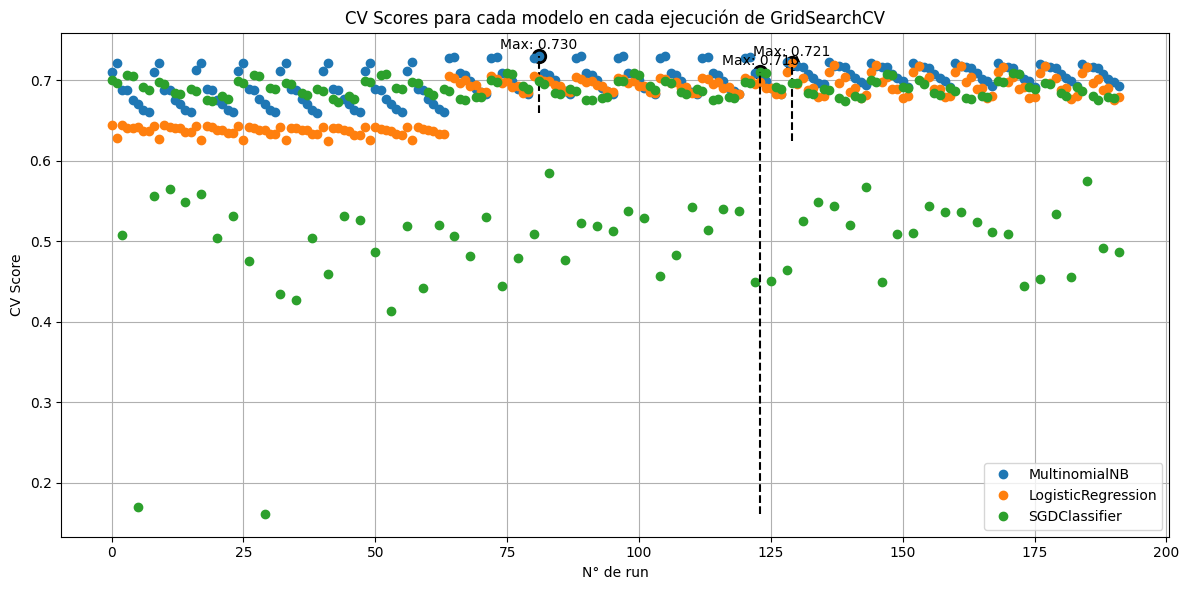

In [184]:
plt.figure(figsize=(12, 6))

for idx, (name, scores) in enumerate(all_scores.items()):
    max_index = scores.index(max(scores))
    plt.plot(range(len(scores)), scores, marker='o', linestyle='None', label=name)
    plt.scatter(max_index, scores[max_index], color='black', s=100)
    plt.vlines(max_index, min(scores), max(scores), color='black', linestyles='dashed')
    plt.text(max_index, max(scores)+0.005, f"Max: {max(scores):.3f}", ha='center', va='bottom', color='black')
    
plt.legend()
plt.xlabel('N° de run')
plt.ylabel('CV Score')
plt.title('CV Scores para cada modelo en cada ejecución de GridSearchCV')

plt.grid(True)
plt.tight_layout()
plt.show()

In [185]:
for name, result in best_scores_and_params.items():
    print(f"Best score (CV) for {name}: {result['best_score']:.4f} with params:")
    for param, value in result['best_params'].items():
        print(f"\t{param}: {value}")
        
    print(f"Media: {np.mean(all_scores[name]):.4f}\t Desvío estándar: {np.std(all_scores[name]):.4f}")
        
    print()

Best score (CV) for MultinomialNB: 0.7303 with params:
	mnb__alpha: 0.01
	pipeline_basic__tfidf__use_idf: True
	pipeline_basic__vect__max_df: 0.14
	pipeline_basic__vect__min_df: 1
	pipeline_basic__vect__ngram_range: (1, 2)
	pipeline_basic__vect__stop_words: english
Media: 0.6993	 Desvío estándar: 0.0193

Best score (CV) for LogisticRegression: 0.7212 with params:
	lr__C: 10
	lr__max_iter: 1000
	lr__solver: sag
	pipeline_basic__tfidf__use_idf: True
	pipeline_basic__vect__max_df: 0.1
	pipeline_basic__vect__min_df: 1
	pipeline_basic__vect__ngram_range: (1, 2)
	pipeline_basic__vect__stop_words: english
Media: 0.6756	 Desvío estándar: 0.0288

Best score (CV) for SGDClassifier: 0.7099 with params:
	pipeline_basic__tfidf__use_idf: True
	pipeline_basic__vect__max_df: 0.2
	pipeline_basic__vect__min_df: 1
	pipeline_basic__vect__ngram_range: (1, 2)
	pipeline_basic__vect__stop_words: english
	sgd__alpha: 0.001
Media: 0.6249	 Desvío estándar: 0.1009



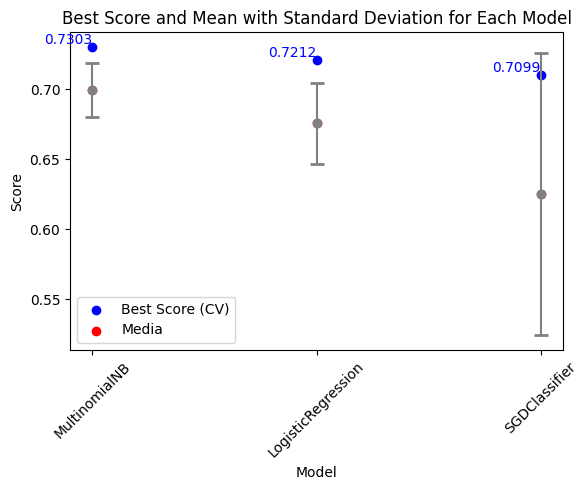

In [186]:
models_names = list(best_scores_and_params.keys())
best_scores = [best_scores_and_params[model]['best_score'] for model in models_names]
means = [np.mean(all_scores[model]) for model in models_names]
stds = [np.std(all_scores[model]) for model in models_names]

plt.figure(figsize=(6, 5))

for i, model in enumerate(models_names):
    plt.errorbar(model, means[i], yerr=stds[i], fmt='o', color='gray', capsize=5, capthick=2)
    plt.text(model, best_scores[i], f'{best_scores[i]:.4f}', ha='right', va='bottom', color='blue')
    
plt.scatter(models_names, best_scores, color='blue', label='Best Score (CV)')
plt.scatter(models_names, means, color='red', label='Media')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Best Score and Mean with Standard Deviation for Each Model')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


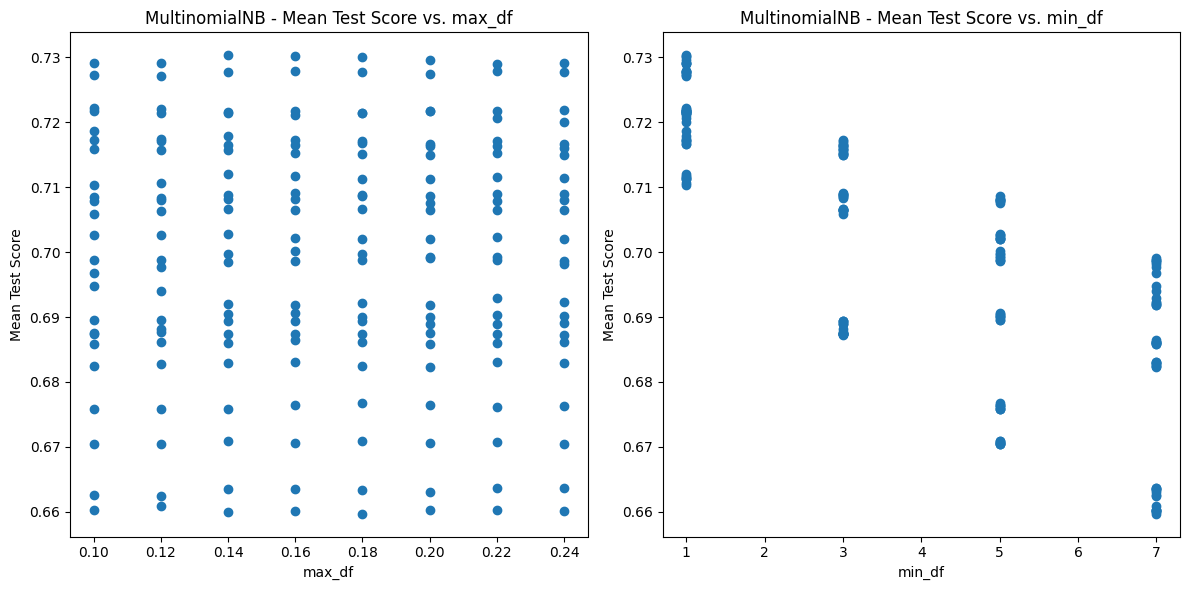

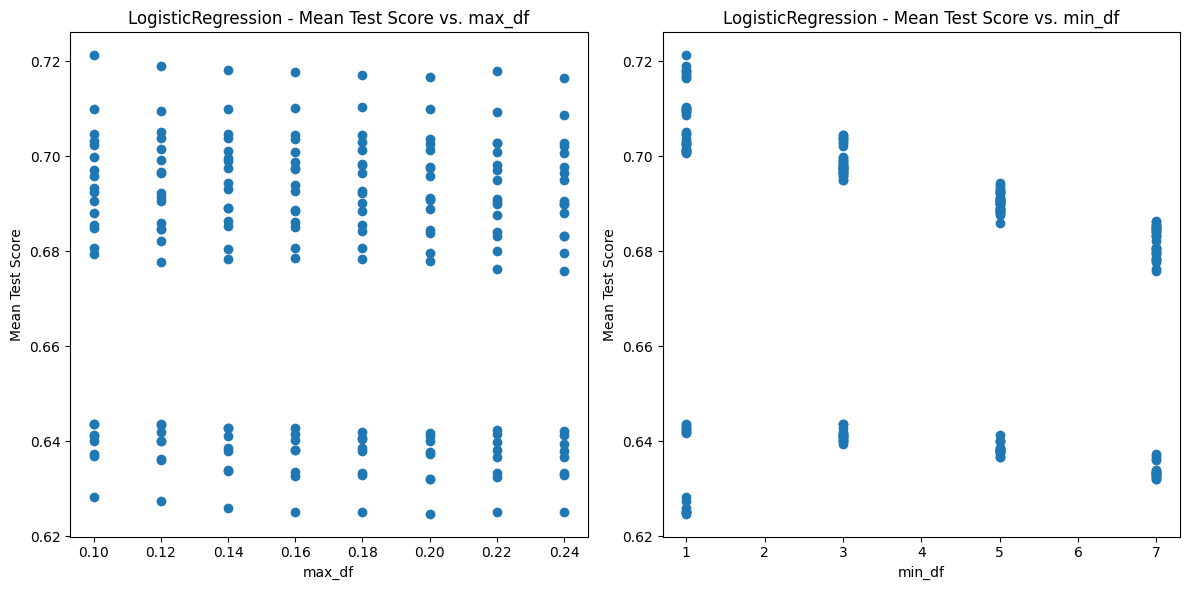

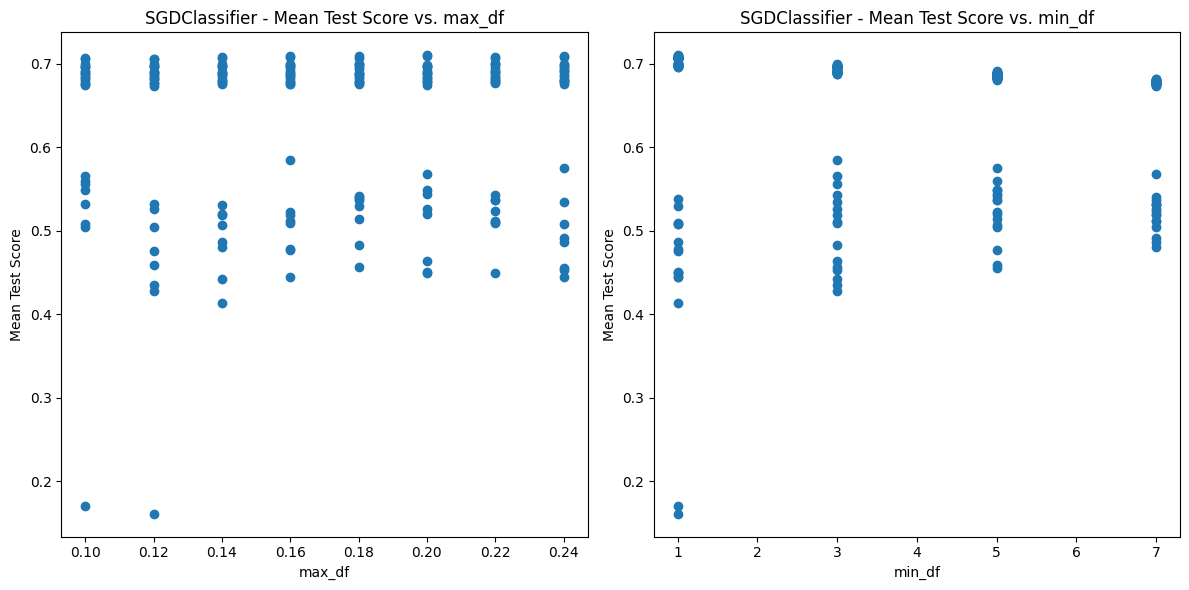

In [187]:
# Inicializa diccionarios para almacenar los resultados de cada modelo
max_df_scores = {}
min_df_scores = {}

# Itera sobre los modelos
for name, pipeline, grid, short_name in models:
    # Carga los resultados de la búsqueda de grilla
    result_file = f"grid_{short_name}.pkl"
    with open(result_file, 'rb') as fp:
        grid_search_data = pickle.load(fp)

    # Extrae los valores de max_df y los scores correspondientes
    max_df_values = [params['pipeline_basic__vect__max_df'] for params in grid_search_data.cv_results_['params']]
    scores = grid_search_data.cv_results_['mean_test_score']

    # Almacena los scores en el diccionario de max_df_scores
    max_df_scores[name] = (max_df_values, scores)

    # Extrae los valores de min_df y los scores correspondientes
    min_df_values = [params['pipeline_basic__vect__min_df'] for params in grid_search_data.cv_results_['params']]
    scores = grid_search_data.cv_results_['mean_test_score']

    # Almacena los scores en el diccionario de min_df_scores
    min_df_scores[name] = (min_df_values, scores)

# Crea los gráficos para cada modelo
for name, pipeline, grid, short_name in models:
    plt.figure(figsize=(12, 6))

    # Gráfico para max_df
    plt.subplot(1, 2, 1)
    max_df_values, scores = max_df_scores[name]
    plt.scatter(max_df_values, scores, marker='o')
    plt.xlabel('max_df')
    plt.ylabel('Mean Test Score')
    plt.title(f'{name} - Mean Test Score vs. max_df')

    # Gráfico para min_df
    plt.subplot(1, 2, 2)
    min_df_values, scores = min_df_scores[name]
    plt.scatter(min_df_values, scores, marker='o')
    plt.xlabel('min_df')
    plt.ylabel('Mean Test Score')
    plt.title(f'{name} - Mean Test Score vs. min_df')

    plt.tight_layout()
    plt.show()

### <a id='toc1_2_6_'></a>[Resultados: validación en train y test](#toc0_)

Se instancian los modelos con los mejores parámetros hallados, en formato pipeline.

In [188]:
best_models = {}

for name, result in best_scores_and_params.items():
    pipeline, _, _ = next(filter(lambda x: x[0] == name, models))[1:]
    pipeline.set_params(**result['best_params'])
    best_models[name] = pipeline
    print(pipeline)
    print()

Pipeline(steps=[('pipeline_basic',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(max_df=0.14,
                                                  ngram_range=(1, 2),
                                                  stop_words='english')),
                                 ('tfidf', TfidfTransformer())])),
                ('mnb', MultinomialNB(alpha=0.01))])

Pipeline(steps=[('pipeline_basic',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(max_df=0.1,
                                                  ngram_range=(1, 2),
                                                  stop_words='english')),
                                 ('tfidf', TfidfTransformer())])),
                ('lr', LogisticRegression(C=10, max_iter=1000, solver='sag'))])

Pipeline(steps=[('pipeline_basic',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(max_df=0.2,
                         

Se fittea cada modelo con el dataset de train y luego se lo scorea.

Notar que `train_data` es el dataset que sale de la tokenización, por lo que al invocar los `fit` y `score`, se countvectoriza y se tfidfea internamente (los `best_models` son pipelines).

El train score resulta evaluando sobre el dataset de train original.

El CV (cross-validation) score es el que surgió del GridSearchCV, ejecutado con `cv=2`, por lo que el `train_data` original fue partido para hacer cross-validations y luego tomar promedio de los scores que resulten.

El test score resulta evaluando íntegramente sobre el dataset de test original, que hasta ahora nunca fue usado.

In [189]:
train_scores = {}
test_scores = {}

for name, model in best_models.items():
    model.fit(train_data, twenty_train.target)
    train_scores[name] = model.score(train_data, twenty_train.target)
    test_scores[name] = model.score(test_data, twenty_test.target)

    print(f"Train score para {name}: {train_scores[name]:.4f}")
    print(f"CV score para {name}: {best_scores_and_params[name]['best_score']:.4f}")
    print(f"Test score para {name}: {test_scores[name]:.4f}\n")

Train score para MultinomialNB: 0.9701
CV score para MultinomialNB: 0.7303
Test score para MultinomialNB: 0.6936

Train score para LogisticRegression: 0.9730
CV score para LogisticRegression: 0.7212
Test score para LogisticRegression: 0.6823

Train score para SGDClassifier: 0.9533
CV score para SGDClassifier: 0.7099
Test score para SGDClassifier: 0.6751



Testeamos la predicción de clases para textos randoms, que apuntan a corresponder a alguna de las clases del dataset.

In [191]:
random_texts = [
    # Cooking Recipes (rec.food.cooking)
    "Forget boxed mixes and grocery store disappointments. This step-by-step guide unlocks the secrets to creating an unforgettable chocolate cake from scratch. We'll delve into the science behind perfect texture and rich flavor, exploring the impact of different ingredients and techniques. From selecting the ideal cocoa powder to mastering the art of folding in egg whites, you'll gain the confidence to tackle variations like decadent dark chocolate ganache or a delightful raspberry swirl. Impress your loved ones with a homemade centerpiece that embodies pure chocolate indulgence. This journey isn't just about a cake; it's about unlocking your inner baking artist and crafting a culinary masterpiece that speaks volumes.",

    # New Technologies (comp.sys.mac.hardware)
    "In today's ever-evolving technological landscape, staying ahead of the curve is crucial. This comprehensive guide delves into the latest hardware innovations specifically designed to elevate your Mac experience. We'll explore the groundbreaking advancements in processor technology, from the power efficiency of M-series chips to the raw processing muscle of high-end desktop configurations. Unveil the secrets of stunning visuals with in-depth explorations of high-resolution displays, from breathtaking Retina options to cutting-edge Pro Display XDR technology. But performance isn't everything. We'll equip you with the knowledge to optimize your Mac for both speed and efficiency, covering memory management, storage optimization, and software configuration best practices. This isn't just about hardware specs; it's about harnessing the full potential of your Mac and maximizing your productivity, creativity, and entertainment. Whether you're a casual user browsing the web or a power user pushing the boundaries of creative applications, this guide empowers you to get the most out of your investment.",

    # International Politics (talk.politics.misc)
    "The world stage is a complex and ever-shifting landscape. This in-depth analysis equips you to navigate the labyrinth of international politics by dissecting the most pressing political events unfolding across the globe. We'll delve into the intricacies of international relations, exploring the dynamics between nations, the formation of alliances, and the challenges of fostering global cooperation. From regional conflicts like the ongoing tensions in the Middle East to the complexities of international trade agreements, we'll unpack the nuances of these issues and provide diverse perspectives for informed analysis. Understanding the impact of political decisions on global security, economic stability, and societal well-being is paramount. This exploration goes beyond headlines, encouraging critical thinking and fostering meaningful discussions about the challenges and opportunities that shape our world order. Engage with experts, analyze data, and explore potential solutions – your voice matters in the global conversation.",

    # Extreme Sports (rec.sport.climbing)
    "The thrill of scaling sheer rock walls, the rush of adrenaline with every challenging move – sport climbing is an activity that pushes boundaries and ignites a passion for adventure. This comprehensive guide welcomes you into this exhilarating world, catering to both aspiring climbers and seasoned veterans alike. Beginners will embark on a structured learning journey, from mastering basic safety protocols and essential climbing techniques to conquering their first indoor routes. Experienced climbers will discover a treasure trove of resources, including in-depth reviews of iconic climbing destinations worldwide, detailed analysis of challenging routes, and insightful training tips to elevate their performance. Whether you're drawn to the mental focus required for bouldering or the endurance challenges of long multi-pitch climbs, this guide equips you with the knowledge and inspiration to pursue your climbing aspirations. Join the vibrant climbing community, participate in local competitions, and embark on unforgettable climbing expeditions. The world of sport climbing awaits!",

    # Military History (talk.politics.guns)
    "From primitive muskets on the battlefields of medieval Europe to the sophisticated weaponry of modern warfare, firearms have played a pivotal role in shaping human history. This exploration delves into the fascinating narrative of their evolution, examining the technological advancements that transformed them from rudimentary tools to instruments of immense power. We'll uncover the political and social implications of firearms throughout history, analyzing their impact on warfare, the rise of nation-states, and the evolution of civil liberties. The ongoing debate surrounding gun control will be explored from historical and contemporary perspectives, inviting critical analysis of the Second Amendment and its interpretation in the face of evolving social circumstances. Engage in thoughtful discussions about self-defense, responsible gun ownership, and the potential for legislative solutions to curb gun violence. Understanding the historical and political context surrounding firearms is crucial for navigating complex contemporary debates and fostering a safer future for all."
]

random_texts_tok = list()

for text in random_texts:
    random_texts_tok.append(preprocess_article(text))

for text in random_texts_tok:
    print(text)
    print()
    
print()

for name, model in best_models.items():
    predictions = model.predict(random_texts)
    predicted_classes = [twenty_train.target_names[pred] for pred in predictions]

    print(f"Predicciones del modelo {name}: {predicted_classes}")

forget box mix groceri store disappoint thi guid unlock secret creat unforgett chocol cake scratch we delv scienc behind perfect textur rich flavor explor impact differ ingredi techniqu from select ideal cocoa powder master art fold egg white gain confid tackl variat like decad dark chocol ganach delight raspberri swirl impress love one homemad centerpiec embodi pure chocol indulg thi journey cake unlock inner bake artist craft culinari masterpiec speak volum

in today technolog landscap stay ahead curv crucial thi comprehens guid delv latest hardwar innov specif design elev mac experi we explor groundbreak advanc processor technolog power effici chip raw process muscl desktop configur unveil secret stun visual explor display breathtak retina option pro display xdr technolog but perform everyth we equip knowledg optim mac speed effici cover memori manag storag optim softwar configur best practic thi hardwar spec har full potenti mac maxim product creativ entertain whether casual user b